#LSM using the TI 46 dataset

##Data exploration and preprocessing to produce .npy files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io
import numpy as np
from numpy import float64
#from lyon.calc import LyonCalc
#from spikes import encoder
import pandas as pd

In [3]:
#data_path = '/content/drive/MyDrive/Colab Notebooks/data_to_export.mat'
#data_path = '/content/drive/MyDrive/bud/data_to_export.mat'
data_path = 'D:\\LSMs\\Liquid-State-Machines\\Data\\data_to_export.mat'
mat = scipy.io.loadmat(data_path)

df_data = pd.DataFrame(columns = ['Spike Data', 'Speaker', 'Type'])

df_data['Spike Data'] = mat['x']['S'][0]
df_data['Speaker'] = [np.squeeze(element) for element in list(mat['x']['spk'][0])]
df_data['Type'] = [np.squeeze(element) for element in list(mat['x']['type'][0])]

In [4]:
df_data.head()

,Spike Data,Speaker,Type
0,"(33, 456)\t1\n (32, 458)\t1\n (33, 465)\t1...",1,0
1,"(73, 262)\t1\n (73, 271)\t1\n (72, 275)\t1...",1,0
2,"(0, 264)\t1\n (0, 271)\t1\n (0, 277)\t1\n ...",1,0
3,"(0, 273)\t1\n (0, 280)\t1\n (0, 285)\t1\n ...",1,0
4,"(34, 288)\t1\n (33, 289)\t1\n (9, 294)\t1\...",1,0


In [5]:
df_data['Spike Data'][1]

<77x1045 sparse matrix of type '<class 'numpy.uint8'>'
	with 2634 stored elements in Compressed Sparse Column format>

In [6]:
data_size=len(df_data)
data_size

19038

In [7]:
df_data = df_data.sample(frac=1).reset_index(drop=True)

In [8]:
df_data['Spike Data']=df_data['Spike Data'].apply(lambda x:np.transpose(x.toarray())) #change to sparse representation

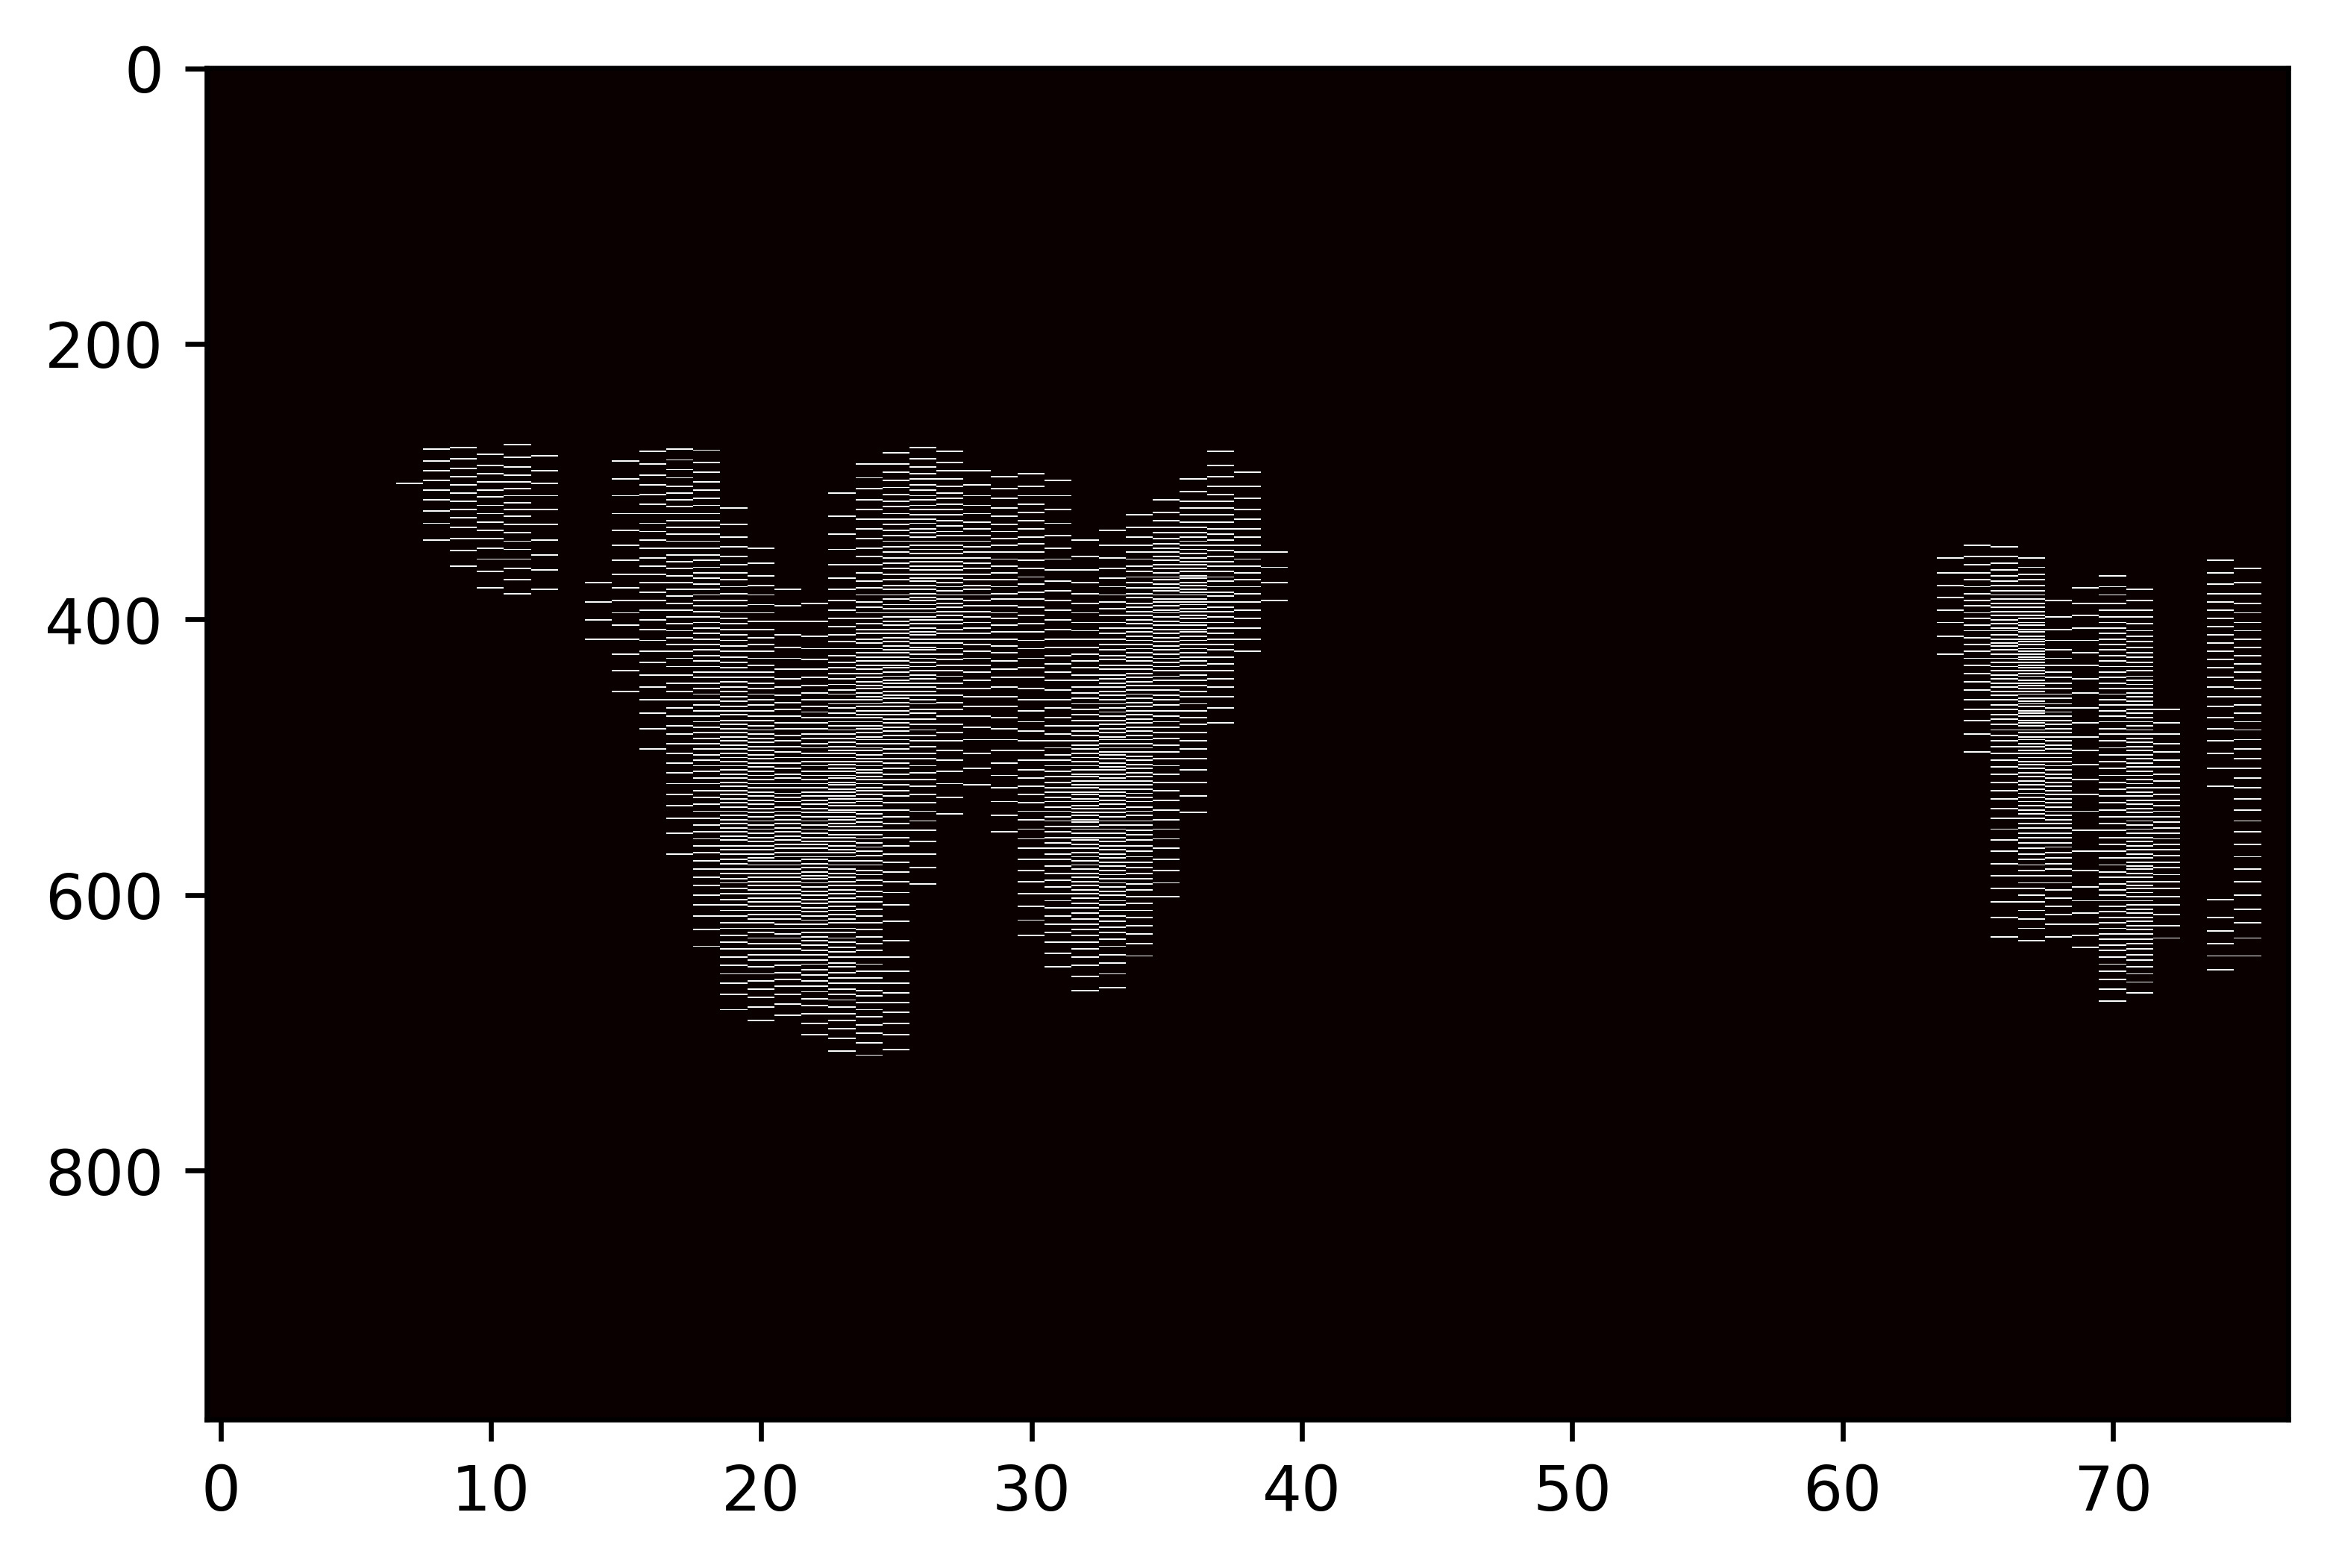

In [11]:
#plt.figure(figsize = (100, 10))
plt.gcf().set_dpi(600)
plt.imshow(df_data['Spike Data'][800], cmap='hot', interpolation='nearest', aspect = 'auto')
plt.show()

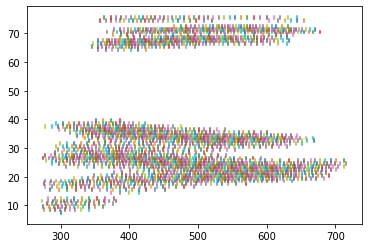

In [10]:
import matplotlib.pyplot as plt
spikeArray=df_data['Spike Data'][800]
for channel in range(spikeArray.shape[1]):
  for t in range(spikeArray.shape[0]):
    if spikeArray[t,channel]:
      plt.plot([t,t],[channel,channel+1])
plt.show()

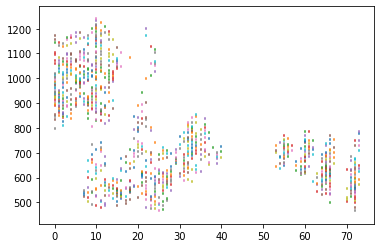

In [18]:
spikeArray=df_data['Spike Data'][8000]
for channel in range(spikeArray.shape[1]):
  for t in range(spikeArray.shape[0]):
    if spikeArray[t,channel]:
      plt.plot([t,t],[channel,channel+1])
plt.show()

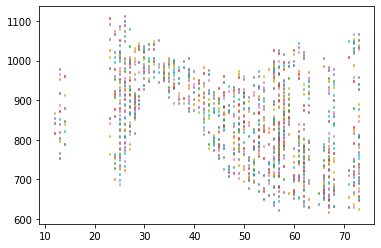

In [21]:
spikeArray=df_data['Spike Data'][18400]
for channel in range(spikeArray.shape[1]):
  for t in range(spikeArray.shape[0]):
    if spikeArray[t,channel]:
      plt.plot([t,t],[channel,channel+1])
plt.show()

##LSM training

In [41]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os

In [12]:
if(not(os.path.exists('/content/drive/'))):
  from google.colab import drive
  drive.mount('/content/drive')

In [42]:
x_shape2=df_data['Spike Data'][1].shape[1]
x_shape2

77

In [43]:
data_size_test = data_size//5; #changed train test split to 80:20 from 90:10

data_size_train = data_size-data_size_test

In [44]:
y_test=(df_data['Type'][-data_size_test:].astype(np.uint64)).to_numpy()
y_in_train=(df_data['Type'][:-data_size_test].astype(np.uint64)).to_numpy()

In [45]:
Nx = 10
Ny = 10
Nz = 10
#Nx=10?
N = Nx*Ny*Nz
LqW = 3 # use 3 for Nx=Ny=Nz = 10, 2 for Nx=Ny=Nz = 12
in_conn_density = 0.08 # 0.15 # 0.4 0.05
inh_fr = 0.35 #0.2 0.45
lam = 3 #4 9 15

in_size = x_shape2

W_lsm = np.zeros((N,N))
W_in = np.zeros((in_size,N))
W_lsm_mask = np.ones((N,N))

in_conn_range = np.int32(N*in_conn_density)
for i in range(in_size):
  input_perm_i = np.arange(N)
  np.random.shuffle(input_perm_i)
  pos_conn = input_perm_i[:in_conn_range]
  neg_conn = input_perm_i[-in_conn_range:]
  W_in[i,pos_conn] = LqW
  W_in[i,neg_conn] = -LqW

input_perm = np.arange(N)
np.random.shuffle(input_perm) # first 0.2*N indices are inhibitory
inh_range = np.int32(inh_fr*N) # indices 0 to inh_range-1 are inhibitory

for i in range(N):
  posti = input_perm[i] # input_perm[i] is the post-neuron index
  zi = posti//(Nx*Ny)
  yi = (posti-zi*Nx*Ny)//Nx
  xi = (posti-zi*Nx*Ny)%Nx
  for j in range(N):
    prej = input_perm[j] # input_perm[j] is the pre-neuron index
    zj = prej//(Nx*Ny)
    yj = (prej-zj*Nx*Ny)//Nx
    xj = (prej-zj*Nx*Ny)%Nx
    D = ((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2)
    if i<inh_range and j<inh_range: # II connection, C = 0.3
      P = 0.3*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
    if i<inh_range and j>=inh_range: # EI connection, C = 0.1
      P = 0.1*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = LqW
    if i>=inh_range and j<inh_range: # IE connection, C = 0.05
      P = 0.05*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = -LqW
    if i>=inh_range and j>=inh_range: # EE connection, C = 0.2
      P = 0.2*np.exp(-D/lam)
      Pu1 = np.random.uniform()
      if Pu1<P:
        W_lsm[prej,posti] = LqW

for i in range(N):
  W_lsm[i,i] = 0
  W_lsm_mask[i,i] = 0

print("average fan out: ", np.mean(np.sum(W_lsm, axis=1)/LqW))

average fan out:  1.244


In [46]:
def run_LSM(Vm,Sin,in_W,W_lsm,num_iter,batch_size,N,tau_u,tau_v,th):
  S_liq=[]
  SI=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  #c_in=tf.convert_to_tensor(np.zeros((batch_size,Sin.shape[2])),dtype=tf.float32)
  #c_lsm=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  u=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  ref_counter=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  for i in range(num_iter):
    #c_in=(np.exp(-1/tau_u))*c_in+(1/tau_u)*Sin[:,i,:]
    #c_lsm=(np.exp(-1/tau_u))*c_lsm+(1/tau_u)*SI
    u=np.exp(-1/tau_u)*u+tf.matmul(Sin[:,i,:],in_W)+tf.matmul(SI,W_lsm)
    #u=tf.matmul(c_in,in_W)+tf.matmul(c_lsm,W_lsm)
    Vm=((1-1/tau_v)*Vm+u-th*SI)*(tf.cast(ref_counter==0,dtype=tf.float32))
    ref_counter=ref_counter+tf.cast(Vm>=th,dtype=tf.float32)*2-tf.cast(ref_counter>0,dtype=tf.float32)
    SI=tf.cast(Vm>=th,dtype=tf.float32)
    #ref_counter=2*(SI)+ref_counter
    Vm=tf.cast(Vm<th,dtype=tf.float32)*Vm
    S_liq.append(SI)
  return tf.stack(S_liq,axis=1)

In [47]:
def run_LSM_STDP(Vm,Sin,in_W,W_lsm,num_iter,batch_size,N,tau_u,tau_v,th,A_p,A_m,t_pl=10,t_mi=10,t_astro=5,w_astro=0.01,ap=0.1,am=0.1):
  S_liq=[]
  SI=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  #c_in=tf.convert_to_tensor(np.zeros((batch_size,Sin.shape[2])),dtype=tf.float32)
  #c_lsm=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  u=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  ref_counter=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  T_in=tf.convert_to_tensor(np.zeros((batch_size,Sin.shape[2])),dtype=tf.float32)
  T_lsm=tf.convert_to_tensor(np.zeros((batch_size,N)),dtype=tf.float32)
  for i in range(num_iter):
    #c_in=(np.exp(-1/tau_u))*c_in+(1/tau_u)*Sin[:,i,:]
    #c_lsm=(np.exp(-1/tau_u))*c_lsm+(1/tau_u)*SI
    u=np.exp(-1/tau_u)*u+tf.matmul(Sin[:,i,:],in_W)+tf.matmul(SI,W_lsm)
    #u=tf.matmul(c_in,in_W)+tf.matmul(c_lsm,W_lsm)
    Vm=((1-1/tau_v)*Vm+u-th*SI)*(tf.cast(ref_counter==0,dtype=tf.float32))
    ref_counter=ref_counter+tf.cast(Vm>=th,dtype=tf.float32)*2-tf.cast(ref_counter>0,dtype=tf.float32)
    SI=tf.cast(Vm>=th,dtype=tf.float32)
    #ref_counter=2*(SI)+ref_counter
    Vm=tf.cast(Vm<th,dtype=tf.float32)*Vm
    S_liq.append(SI)

    T_in = (1-1/t_pl)*T_in + (ap/t_pl)*Sin[:,i,:]
    T_lsm = (1-1/t_mi)*T_lsm + (am/t_mi)*SI
    
    """in_W=in_W+(A_p*tf.matmul(tf.transpose(T_in),SI))/batch_size-(A_m*tf.matmul(tf.transpose(Sin[:,i,:]),T_lsm))/batch_size
    in_W=tf.cast(abs(in_W)<=3,dtype=tf.float32)*in_W+tf.cast(in_W>3,dtype=tf.float32)*3+tf.cast(in_W<-3,dtype=tf.float32)*(-3)
    W_lsm=W_lsm+(A_p*tf.matmul(tf.transpose(T_lsm),SI))/batch_size-(A_m*tf.matmul(tf.transpose(SI),T_lsm))/batch_size
    W_lsm=tf.cast(abs(W_lsm)<=3,dtype=tf.float32)*W_lsm+tf.cast(W_lsm>3,dtype=tf.float32)*3+tf.cast(W_lsm<-3,dtype=tf.float32)*(-3)"""

    in_W=in_W+(A_p*tf.matmul(tf.transpose(T_in),SI))/(batch_size)-(A_m*tf.matmul(tf.transpose(Sin[:,i,:]),T_lsm))/(batch_size)
    in_W=tf.cast(abs(in_W)<=3,dtype=tf.float32)*in_W+tf.cast(in_W>3,dtype=tf.float32)*3+tf.cast(in_W<-3,dtype=tf.float32)*(-3)
    W_lsm=W_lsm+(A_p*tf.matmul(tf.transpose(T_lsm),SI))/(batch_size)-(A_m*tf.matmul(tf.transpose(SI),T_lsm))/(batch_size)
    W_lsm=tf.cast(abs(W_lsm)<=3,dtype=tf.float32)*W_lsm+tf.cast(W_lsm>3,dtype=tf.float32)*3+tf.cast(W_lsm<-3,dtype=tf.float32)*(-3)
    
    #Boosting w_astro
    #w_boost=(N+Sin.shape[2])/2
    #w_boost=(N*Sin.shape[2])**0.5
    #w_boost=(N*Sin.shape[2])/(N+Sin.shape[2])
    w_boost=1

    #Scheme 1
    #A_m=(1-1/t_astro)*A_m+(1/t_astro)*((w_astro)*tf.reduce_mean(tf.reduce_sum(SI,axis=1)).numpy()-(w_astro)*tf.reduce_mean(tf.reduce_sum(Sin[:,i,:],axis=1)).numpy()+A_p)

    #Scheme 2
    A_m=(1-1/t_astro)*A_m+(1/t_astro)*((w_astro*w_boost/N)*tf.reduce_mean(tf.reduce_sum(SI,axis=1)).numpy()-(w_astro*w_boost/Sin.shape[2])*tf.reduce_mean(tf.reduce_sum(Sin[:,i,:],axis=1)).numpy()+A_p)

    #trying to decay A_p
    #A_p=A_p*0.99
    #A_p=A_p*(1-1/1e6)
    A_p=A_p*(1-(A_p**2)/1e5)
    #Scheme 3
    #A_m=(1-1/t_astro)*A_m+(1/t_astro)*((w_astro/(N*batch_size))*tf.reduce_mean(tf.reduce_sum(SI,axis=1)).numpy()-(w_astro/(Sin.shape[2])*tf.reduce_mean(tf.reduce_sum(Sin[:,i,:],axis=1)).numpy()+A_p)
    
  S_liq = tf.stack(S_liq,axis=1)
  return S_liq, W_lsm,in_W,A_m,A_p

In [48]:
#STDP in LSM

batch_size = 100
num_iter=100
#num_iter = to be computed on the fly

sum_train=0
sum_iter_train=0
sum_test=0
sum_iter_test=0

W_lsm_tf = tf.constant(W_lsm, dtype=tf.float32)

# Try multimodal W_lsm from MNIST
#W_lsm_tf = tf.constant(W_lsm_multi, dtype=tf.float32)

W_in_tf = tf.constant(W_in, dtype=tf.float32)

tau_v=64
tau_u=1
delta=1
th=10 #replace by 20
A_p=0.15
A_m=0.15

num_batches = data_size_train//batch_size
num_batches_test = data_size_test//batch_size
num_partitions = 4
LSM_out_train = np.zeros((data_size_train,num_partitions*N))
LSM_out_test = np.zeros((data_size_test,num_partitions*N))

w_scale = 1
#partition = num_iter//num_partitions

num_epochs=1
for epoch in range(num_epochs):
  print("Running epoch "+str(epoch+1))
  for b in range(num_batches):
    if(b%4==0):
      print("Epoch " + str(epoch+1)+ " completed: " + str(b/num_batches))
    Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
    #SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
    #SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
    #spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
    #shapes=df_data['Spike Data'][b*batch_size:(b+1)*batch_size].apply(lambda x:x.shape[0])
  
    """x_d=[]
    if(min(shapes)!=max(shapes)):
      d=df_data['Spike Data'][b*batch_size:(b+1)*batch_size].apply(lambda x:(np.concatenate((x,np.zeros((max(shapes)-x.shape[0],x.shape[1]))))).astype(np.uint64))
    x_=d.apply(lambda x:x_d.append(x))
    x_d=np.array(x_d)
    num_iter=x_d.shape[1]
    partition = num_iter//num_partitions
    sum_train=sum_train+np.sum(x_d)
    sum_iter_train=sum_iter_train+num_iter*batch_size*x_d.shape[2]"""
    #sum_train=sum_train+np.sum(x_d)/(num_iter*x_d.shape[2])
    x_d=[]
    def ret_slice(x):
      idx=np.random.randint(0,x.shape[0]-num_iter)
      return x[idx:idx+num_iter]
    d=df_data['Spike Data'][b*batch_size:(b+1)*batch_size].apply(lambda x:ret_slice(x))
    x_=d.apply(lambda x:x_d.append(x))
    x_d=np.array(x_d)
    partition=num_iter//num_partitions
    sum_train=sum_train+np.sum(x_d)
    sum_iter_train=sum_iter_train+num_iter*batch_size*x_d.shape[2]

    batch_in_full = x_d
    batch_in_full_tf = tf.constant(batch_in_full, dtype=tf.float32)

    #S_liq = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)
    S_liq,W_lsm_tf,W_in_tf,A_m,A_p= run_LSM_STDP(Vm_tf,batch_in_full_tf,W_in_tf,W_lsm_tf,num_iter,batch_size,N,tau_u,tau_v,th,A_p,A_m)
  
  """S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)
  
  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)

  #S_liq_c = tf.reduce_mean(S_liq, axis=1)

  LSM_out_train[b*batch_size:(b+1)*batch_size] = S_liq_c.numpy()"""

Running epoch 1
Epoch 1 completed: 0.0
Epoch 1 completed: 0.02631578947368421
Epoch 1 completed: 0.05263157894736842
Epoch 1 completed: 0.07894736842105263
Epoch 1 completed: 0.10526315789473684
Epoch 1 completed: 0.13157894736842105
Epoch 1 completed: 0.15789473684210525
Epoch 1 completed: 0.18421052631578946
Epoch 1 completed: 0.21052631578947367
Epoch 1 completed: 0.23684210526315788
Epoch 1 completed: 0.2631578947368421
Epoch 1 completed: 0.2894736842105263
Epoch 1 completed: 0.3157894736842105
Epoch 1 completed: 0.34210526315789475
Epoch 1 completed: 0.3684210526315789
Epoch 1 completed: 0.39473684210526316
Epoch 1 completed: 0.42105263157894735
Epoch 1 completed: 0.4473684210526316
Epoch 1 completed: 0.47368421052631576
Epoch 1 completed: 0.5
Epoch 1 completed: 0.5263157894736842
Epoch 1 completed: 0.5526315789473685
Epoch 1 completed: 0.5789473684210527
Epoch 1 completed: 0.6052631578947368
Epoch 1 completed: 0.631578947368421
Epoch 1 completed: 0.6578947368421053
Epoch 1 comple

In [49]:
batch_size = 100
#num_iter = to be computed on the fly

sum_train=0
sum_iter_train=0
sum_test=0
sum_iter_test=0

# Uncomment next 2 lines for non-STDP run
#W_lsm_tf = tf.constant(W_lsm, dtype=tf.float32)
#W_in_tf = tf.constant(W_in, dtype=tf.float32)

tau_v=64
tau_u=1
delta=1
th=10 #replace by 20

num_batches = data_size_train//batch_size
num_batches_test = data_size_test//batch_size
num_partitions = 4
LSM_out_train = np.zeros((data_size_train,num_partitions*N))
LSM_out_test = np.zeros((data_size_test,num_partitions*N))

w_scale = 1
#partition = num_iter//num_partitions

for b in range(num_batches):
  if(b%4==0):
    print("completed: ", b/num_batches)
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  #SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  #SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  #spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)

  shapes=df_data['Spike Data'][b*batch_size:(b+1)*batch_size].apply(lambda x:x.shape[0])
  
  x_d=[]
  if(min(shapes)!=max(shapes)):
    d=df_data['Spike Data'][b*batch_size:(b+1)*batch_size].apply(lambda x:(np.concatenate((x,np.zeros((max(shapes)-x.shape[0],x.shape[1]))))).astype(np.uint64))
  x_=d.apply(lambda x:x_d.append(x))
  x_d=np.array(x_d)
  num_iter=x_d.shape[1]
  partition = num_iter//num_partitions
  sum_train=sum_train+np.sum(x_d)
  sum_iter_train=sum_iter_train+num_iter*batch_size*x_d.shape[2]
  #sum_train=sum_train+np.sum(x_d)/(num_iter*x_d.shape[2])

  batch_in_full = x_d
  batch_in_full_tf = tf.constant(batch_in_full, dtype=tf.float32)

  #S_liq = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)
  S_liq = run_LSM(Vm_tf,batch_in_full_tf,W_in_tf,W_lsm_tf,num_iter,batch_size,N,tau_u,tau_v,th)
  
  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)
  
  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)

  #S_liq_c = tf.reduce_mean(S_liq, axis=1)

  LSM_out_train[b*batch_size:(b+1)*batch_size] = S_liq_c.numpy()

for b in range(num_batches_test):
  Vm_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  #SI_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
  #SinI_tf = tf.constant(np.zeros((batch_size, in_size)), dtype=tf.float32)
  #spT_tf = tf.constant(np.zeros((batch_size, N)), dtype=tf.float32)
   
  x_d=[]
  shapes=df_data['Spike Data'][-data_size_test+b*batch_size:-data_size_test+(b+1)*batch_size].apply(lambda x:x.shape[0])
  if(min(shapes)!=max(shapes)):
    d=df_data['Spike Data'][-data_size_test+b*batch_size:-data_size_test+(b+1)*batch_size].apply(lambda x:(np.concatenate((x,np.zeros((max(shapes)-x.shape[0],x.shape[1]))))).astype(np.uint64))
  x_=d.apply(lambda x:x_d.append(x))
  x_d=np.array(x_d)
  num_iter=x_d.shape[1]
  partition = num_iter//num_partitions
  sum_test=sum_test+np.sum(x_d)
  sum_iter_test=sum_iter_test+num_iter*batch_size*x_d.shape[2]
  
  batch_in_full = x_d
  batch_in_full_tf = tf.constant(batch_in_full, dtype=tf.float32)

  #S_liq = run_LSM(Vm_tf, SI_tf, batch_in_full_tf, SinI_tf, eta, eta1, a1, a2, W_in_tf, W_lsm_tf, w_scale, th, num_iter)
  S_liq = run_LSM(Vm_tf,batch_in_full_tf,W_in_tf,W_lsm_tf,num_iter,batch_size,N,tau_u,tau_v,th)
  
  S_liq_c1 = tf.reduce_mean(S_liq[:,:partition,:], axis=1)
  S_liq_c2 = tf.reduce_mean(S_liq[:,partition:2*partition,:], axis=1)
  S_liq_c3 = tf.reduce_mean(S_liq[:,2*partition:3*partition,:], axis=1)
  S_liq_c4 = tf.reduce_mean(S_liq[:,-partition:,:], axis=1)
  
  S_liq_c = tf.concat([S_liq_c1, S_liq_c2, S_liq_c3, S_liq_c4], axis=1)

  #S_liq_c = tf.reduce_mean(S_liq, axis=1)

  LSM_out_test[b*batch_size:(b+1)*batch_size] = S_liq_c.numpy()

completed:  0.0
completed:  0.02631578947368421
completed:  0.05263157894736842
completed:  0.07894736842105263
completed:  0.10526315789473684
completed:  0.13157894736842105
completed:  0.15789473684210525
completed:  0.18421052631578946
completed:  0.21052631578947367
completed:  0.23684210526315788
completed:  0.2631578947368421
completed:  0.2894736842105263
completed:  0.3157894736842105
completed:  0.34210526315789475
completed:  0.3684210526315789
completed:  0.39473684210526316
completed:  0.42105263157894735
completed:  0.4473684210526316
completed:  0.47368421052631576
completed:  0.5
completed:  0.5263157894736842
completed:  0.5526315789473685
completed:  0.5789473684210527
completed:  0.6052631578947368
completed:  0.631578947368421
completed:  0.6578947368421053
completed:  0.6842105263157895
completed:  0.7105263157894737
completed:  0.7368421052631579
completed:  0.7631578947368421
completed:  0.7894736842105263
completed:  0.8157894736842105
completed:  0.842105263157

In [50]:
print("mean LSM spiking (train) : ", np.mean(LSM_out_train))
print("mean LSM spiking (test) : ", np.mean(LSM_out_test))

print("mean input spiking (train) : ", sum_train/(sum_iter_train))
print("mean input spiking (test) : ", sum_test/sum_iter_test)

mean LSM spiking (train) :  0.01605735707225517
mean LSM spiking (test) :  0.016850243254168853
mean input spiking (train) :  0.020106829643327714
mean input spiking (test) :  0.020468108075619645


In [51]:
from sklearn import linear_model
from sklearn.metrics import ConfusionMatrixDisplay

print("training linear model on LSM")
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
clf.fit(LSM_out_train, y_in_train)

train_score = clf.score(LSM_out_train, y_in_train)
print("train score = " + str(train_score))

score = clf.score(LSM_out_test, y_test)
print("test score = " + str(score))

#print("training linear model on direct input")
#clf2 = linear_model.SGDClassifier(max_iter=10000, tol=1e-6)
#clf2.fit(np.mean(x_in_train, axis=(1)), y_in_train)

#score2 = clf2.score(np.mean(x_test, axis=(1)), y_test)
#print("test score without LSM = " + str(score2))

training linear model on LSM
train score = 0.925546582627536
test score = 0.014447071184659837


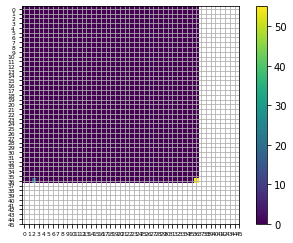

In [52]:
test_predict = clf.predict(LSM_out_test)
cm = confusion_matrix(y_test, test_predict, labels=clf.classes_)

ticks=np.linspace(0, 45, num=46)
plt.imshow(cm, interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(True)
plt.show()



In [38]:
print("weights: ")
print("min lsm w "+str(np.min(W_lsm_tf)))
print("max lsm w "+str(np.max(W_lsm_tf)))
print("min in w "+str(np.min(W_in_tf)))
print("max in w "+str(np.max(W_in_tf)))
print("A_astro= "+str(A_m))
print("b_astro= "+str(A_p))

weights: 
min lsm w -3.0
max lsm w 3.0
min in w -3.0
max in w 3.0
A_astro= 0.14945324058572654
b_astro= 0.14948961660780127
